[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/tailvar/TAE/blob/master/notebook/aiengineer_wk_1/tae_capstone_wk1.ipynb
)

In [1]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    !pip install numpy matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import OrderedDict

<span style="font-size:16pt; font-weight:bold;">Capstone Project Gradient-Based Optimisation Case Study</span>

This notebook builds on a simple calculus problem to develop intuition for gradient-based optimization. Starting from the one-dimensional function: 
                                                                       
$$
f(x) = \left| \tfrac{1}{2}x^{3} - \tfrac{3}{2}x^{2} \right| + \tfrac{1}{2}x
$$

visually observing its structure — including its piecewise form, stationary points, and global minima. Because the function has a kink at x = 3, it provides a clear example of how optimization methods behave near non-smooth points, where gradients can be unstable or undefined. The notebook uses various versions of Gradient Descent (GD) and Stochastic Gradient Descent (SGD) to visualise how parameter choices influence convergence. All experiments ran for K = 200 iterations and recorded both xₖ and f(xₖ).

<span style="font-size:16pt; font-weight:bold;">The Function</span>

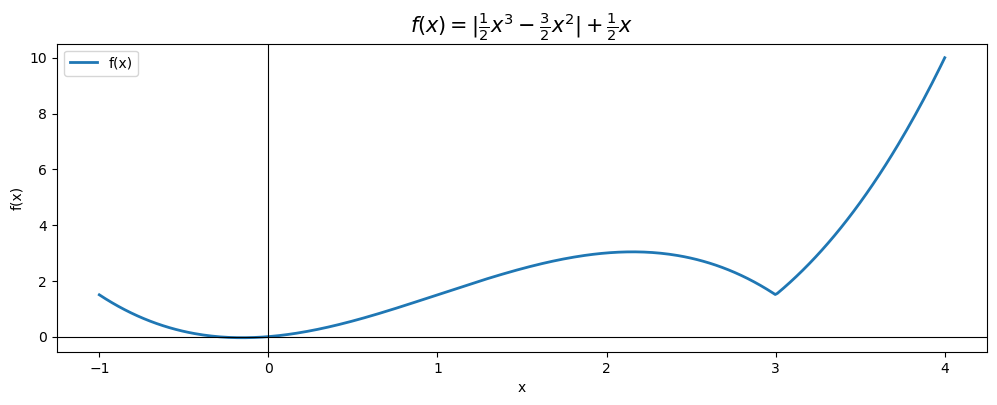

In [3]:
def f(x):
    return np.abs(0.5 * x**3 - 1.5 * x**2) + 0.5 * x

x = np.linspace(-1, 4, 400)
y = f(x)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(x, y, linewidth=2, label="f(x)")
title_str = r"$f(x)=|\frac{1}{2}x^{3}-\frac{3}{2}x^{2}|+\frac{1}{2}x$"
ax.set_title(title_str, fontsize=15, pad=8)

ax.set_xlabel("x"); ax.set_ylabel("f(x)")
ax.axhline(0, color="black", linewidth=0.8)
ax.axvline(0, color="black", linewidth=0.8)
ax.legend()
plt.show()



<span style="font-size:12pt; font-weight:bold;">Optimization Methods</span>

The notebook explores several approaches to iterative optimization:

- <u>Basic Gradient Descent (GD)</u> – follows the negative gradient to locate a local minimum.

- <u>Heavy-Ball Method</u> – adds a momentum term (β) that can accelerate convergence or cause oscillation.

- <u>Stochastic Gradient Descent (SGD)</u> – introduces random noise (σ) to mimic stochastic updates.

- <u>Gradient Descent with Decaying Learning Rate</u> – gradually reduces the step size (η) to smooth convergence.

These algorithms are all applied to the same objective function to show how different combinations of η, β, and σ affect the trajectory toward the minimum.

<span style="font-size:12pt; font-weight:bold;">Structure of the Notebook</span>


From Calculus to Optimization – analytical exploration of f(x), including non-smooth regions and stationary points. 

- <u>Gradient Descent and Heavy-Ball Comparison</u> – visual demonstration of how adding momentum changes convergence behavior.

- <u>Introducing Stochasticity</u> – examines the effect of random noise on the optimization trajectory.

- <u>Decaying Step Size</u> – shows how reducing η over time can prevent divergence and improve stability.

Convergence Visualization – compares optimization paths The convergence of \( f(x_k) \) toward \( f(x^*) \) illustrates how the algorithm approaches the global minimum.


<span style="font-size:12pt; font-weight:bold;">Data and Implementation</span>
           
No external data is required — all experiments are based on the analytical function \(f(x)\) defined above. Each section includes both plots and commentary, with a description of what the experiment shows.The emphasis is on understanding how changes to the learning rate (η), momentum (β), and noise (σ) shape the dynamics of convergence.

</span><span style="font-size:16pt; font-weight:bold;">Function Definitions</span>

In [4]:
# Reproducibility
rng = np.random.default_rng(0)
x_star = 1.0 - (2.0 / 3.0) * np.sqrt(3.0)
f_star = (3.0 / 2.0) - (8.0 / 9.0) * np.sqrt(3.0)

""" 
    objective and derivatives
    f(x) = |g(x)| + 1 / 2 x
    g(x) = 1 / 2 x^3 - 3 / 2 x^2
    kink at x = 3 with subdiff [-4, 5]
"""
def f(x):
    return abs(0.5 * x**3 - 1.5 * x**2) + (0.5 * x)

def g(x):
    return 0.5 * x**3 - 1.5 * x**2

def g_prime(x):
    return 1.5 * x**2 - 3.0 * x

def fprime_piecewise(x):
    """for x != 3 only"""
    if x < 3.0:
        return -g_prime(x) + 0.5
    elif x > 3.0:
        return g_prime(x) + 0.5
    else:
        raise ValueError("Use subgradient at x = 3")

def subgradient_at_3(strategy: str = "min_norm") -> float:
    """
    Convex subdifferentiation at kink: ∂f(3) = [-4, 5].
    'min_norm' -> 0.0, 'left' -> -4.0, 'right' -> +5.0.
    """
    if strategy == "min_norm":
        return 0.0
    if strategy == "left":
        return -4.0
    if strategy == "right":
        return 5.0
    return 0.0  # default to min-norm

def is_kink(x: float, tol: float = 1e-12) -> bool:
    """x should be a distance measured by our tolerance from the kink"""
    return abs(x - 3.0) <= tol

def fgrad(x: float, kink_strategy: str = "min_norm") -> float:
    """Gradient/subgradient selector used by all methods."""
    return subgradient_at_3(kink_strategy) if is_kink(x) else fprime_piecewise(x)

<span style="font-size:16pt; font-weight:bold;">Gradient Descent Algorithms</span>

In [5]:

def run_gd(x0, eta, K, kink_strategy="min_norm"):
    """
    standard gradient descent (constant η) at each iteration we evaluate 
    the gradient at the current point and move in the oppopsite direction.
    The learning rate (constant η) controls how large the step is.
    """
    x = x0
    xs = [x]
    fs = [f(x)]
    for _ in range(K):
        grad = fgrad(x, kink_strategy)
        x = x - eta * grad
        xs.append(x)
        fs.append(f(x))
    return np.array(xs), np.array(fs)

def run_heavy_ball(x0, eta, beta_mom, K, kink_strategy="min_norm"):
    """
    Heavy Ball modifies gradient descent by adding a velocity term 
    controlled by the momentum coefficient β. Intuitiveky the update remembers 
    the previous direction, which can help accelerate the algorithms progress 
    in gentle valleys but ay cause oscillations if is β too high.
    """
    x = x0
    v = 0
    xs = [x]
    fs = [f(x)]
    for _ in range(K):
        grad = fgrad(x, kink_strategy)
        v = beta_mom * v + grad
        x = x - eta * v
        xs.append(x)
        fs.append(f(x))
    return np.array(xs), np.array(fs)

def run_sgd(x0: float, eta: float, K: int, sigma: float,
            kink_strategy: str = "min_norm", rng: np.random.Generator | None = None):
    """
    Stochastic Gradient Descent with constant step. Noise ~ N(0, sigma) is added 
    to the gradient at each step. The noise level determines how volatile the 
    path becomes. Reproducible if an rng is supplied; otherwise a fresh Generator 
    is used.
    """
    rng = np.random.default_rng() if rng is None else rng

    x = float(x0)
    xs = [x]
    fs = [f(x)]

    for _ in range(K):
        gauss_noise = rng.normal(0.0, sigma)
        grad = fgrad(x, kink_strategy)
        x = x - eta * (grad + gauss_noise)
        xs.append(x)
        fs.append(f(x))

    return np.array(xs), np.array(fs)

def run_sgd_decay(x0: float, eta0: float, gamma: float, K: int, sigma: float,
                  kink_strategy: str = "min_norm", rng: np.random.Generator | None = None):
    """
    Stochastic Gradient Descent with diminishing step: eta_k = eta0 / (1 + gamma * k).
    A fixed learning rate can be too aggressive over long horizons. using eta_k 
    early iterations explore widely while later iterations take more cautious steps.
    Noise ~ N(0, sigma). Reproducible if an rng is supplied.
    """
    rng = np.random.default_rng() if rng is None else rng

    x = float(x0)
    xs = [x]
    fs = [f(x)]

    for k in range(K):
        eta_k = eta0 / (1.0 + gamma * k)
        gauss_noise = rng.normal(0.0, sigma)
        grad = fgrad(x, kink_strategy)
        x = x - eta_k * (grad + gauss_noise)
        xs.append(x)
        fs.append(f(x))

    return np.array(xs), np.array(fs)

<span style="font-size:16pt; font-weight:bold;">Gradient Descent and Heavy-Ball Comparison – visual demonstration of how adding momentum changes convergence behavior.</span>

In [6]:
def build_results(x0: float, eta: float, K: int, sigmas_sgd, *,
                  hb_configs=((0.15, 0.5), (0.08, 0.9)),
                  seed = 42):
    """
    Run baseline GD, Heavy-Ball configs, and a sweep of SGD sigmas.
    Ensures reproducible stochastic results using np.random.default_rng(seed).
    Returns an OrderedDict mapping label -> (xs, fs).
    """
    rng = np.random.default_rng(seed)
    results = OrderedDict()

    # Runs for graedient descent and heavy ball
    xs, fs = run_gd(x0, eta, K)
    results["Gradient Descent"] = (np.asarray(xs), np.asarray(fs))

    for (eta_hb, beta) in hb_configs:
        xs, fs = run_heavy_ball(x0, eta_hb, beta, K)
        results[f"Heavy Ball (η={eta_hb}, β={beta})"] = (np.asarray(xs), np.asarray(fs))

    # runs for stochastic gradient descent
    for sig in sigmas_sgd:
        xs, fs = run_sgd(x0, eta, K, sig, "min_norm", rng=rng)
        results[f"Stochastic GD (σ={sig})"] = (np.asarray(xs), np.asarray(fs))

    return results


def plot_results(results, sigmas_sgd, x_star=x_star):
    """
    Plot trajectories: left pane = GD + HB; right pane = SGD sweep.
    Expects `results` from build_results (label -> (xs, fs)).
    """
    left_labels = [lbl for lbl in results if lbl.startswith("Gradient Descent")
                   or lbl.startswith("Heavy Ball")]
    right_labels = [f"Stochastic GD (σ={sig})" for sig in sigmas_sgd]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Left chart
    for lbl in left_labels:
        xs, _ = results[lbl]
        axes[0].plot(xs, label=lbl)
    axes[0].axhline(y=x_star, linestyle="-.", label="x* minimum")
    axes[0].set_title("Gradient Descent + Heavy-Ball")
    axes[0].legend()

    # Right chart
    for lbl in right_labels:
        xs, _ = results[lbl]
        axes[1].plot(xs, label=lbl)
    axes[1].axhline(y=x_star, linestyle="-.", label="x* minimum")
    axes[1].set_title("Stochastic Gradient Descent (constant η)")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


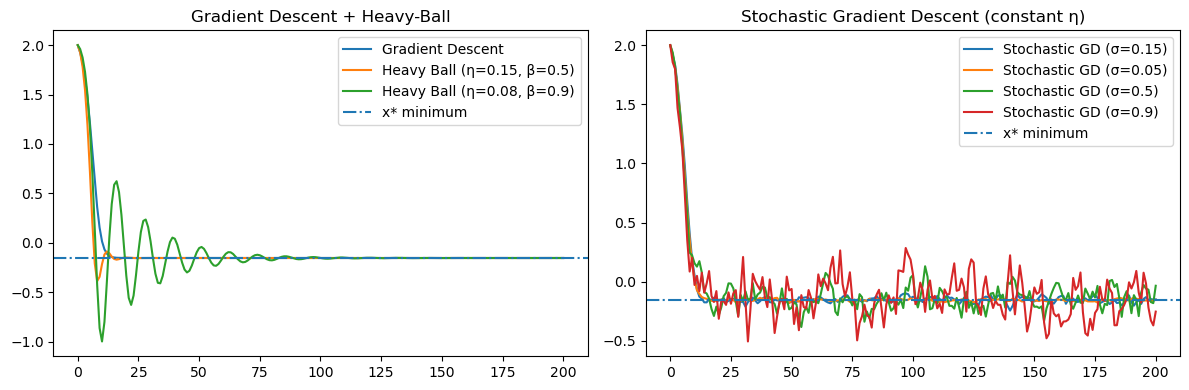

In [7]:
x0 = 2.0
eta = 0.15
K = 200
SIGMAS_SGD = [0.15, 0.05, 0.5, 0.9]
x_star = x_star  # minimum

results = build_results(
    x0=x0,
    eta=eta,
    K=K,
    sigmas_sgd=SIGMAS_SGD,
    hb_configs=((0.15, 0.5), (0.08, 0.9)),
    seed=42,  # reproducible
)

plot_results(results, SIGMAS_SGD, x_star)

Left Chart — Gradient Descent and Heavy-Ball Momentum
The left-hand chart compares standard gradient descent with the heavy-ball method. Heavy_Ball Introduces momentum coefficient (β) which accelerates convergence but can also cause oscillations if β is set too high. With a moderate value (β=0.5), the trajectory reaches the minimum more rapidly than vanilla gradient descent, though it briefly overshoots before settling.

Right Chart — Stochastic Gradient Descent with Fixed Learning Rate. Shows stochastic gradient descent (SGD) using a constant learning rate (η=0.15) and varying levels of noise (σ). The results indicate that increasing σ adds volatility without improving convergence speed. When the noise becomes large, the iterates xk, fail to stabilize near the minimum, highlighting the trade-off between exploration and stability.

<span style="font-size:16pt; font-weight:bold;">Gradient descent with decaying η</span>  

In [8]:
def generate_sgd_decay_data(x0, K, eta_gamma_list, sigma,
                            kink_strategy="min_norm", seed=42):
    """
    Run multiple SGD-decay experiments for (η, γ) tuples. Returns a 
    dict mapping (η, γ) -> (xs, fs). Ensures reproducibility using 
    np.random.default_rng(seed).
    """
    results = {}
    for i, (eta0, gamma) in enumerate(eta_gamma_list):
        rng = np.random.default_rng(seed + i)
        xs, fs = run_sgd_decay(
            x0=x0,
            eta0=eta0,
            gamma=gamma,
            K=K,
            sigma=sigma,
            kink_strategy=kink_strategy,
            rng=rng
        )
        results[(eta0, gamma)] = (xs, fs)
    return results


def plot_sgd_decay_results(results, x_star):
    """
    Plot all SGD-decay runs on a single chart with x* reference line.
    """
    plt.figure(figsize=(12, 6))
    for (eta0, gamma), (xs, fs) in results.items():
        plt.plot(xs, label=f"η₀={eta0}, γ={gamma}")

    plt.axhline(y=x_star, linestyle="-.",label="x* minimum")
    plt.title("Stochastic SG with decaying η")
    plt.xlabel("iteration")
    plt.ylabel("x")
    plt.legend()
    plt.tight_layout()
    plt.show()

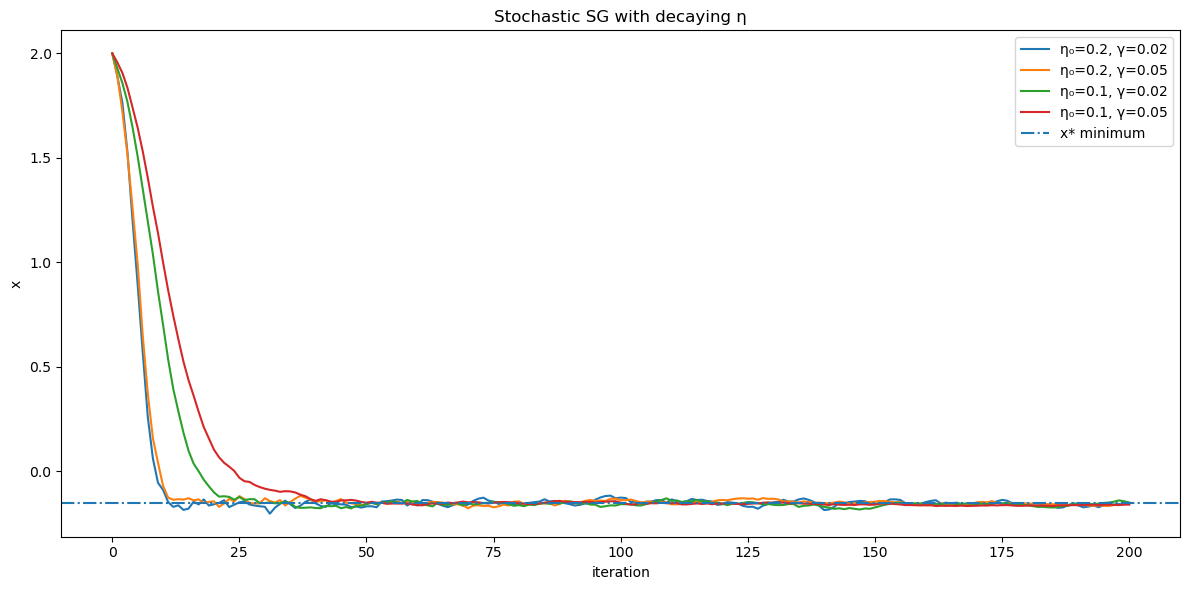

In [9]:
x0 = 2.0
K = 200
x_star = x_star
sigma = 0.15
eta_decay = [(0.2, 0.02), (0.2, 0.05), (0.1, 0.02), (0.1, 0.05)]

results_decay = generate_sgd_decay_data(
    x0=x0,
    K=K,
    eta_gamma_list=eta_decay,
    sigma=sigma,
    kink_strategy="min_norm",
    seed=42
)

plot_sgd_decay_results(results_decay, x_star)

This chart compares several decay schedules for ηk=η0 / 1+γk. A higher initial learning rate (η0) drives the iterates more quickly toward x∗ (the minimum) while a smaller decay constant (γ) maintains momentum for longer and improves overall efficiency. In contrast, starting with a lower η0 (e.g., 0.1) slows convergence and can even lag behind standard gradient descent with a fixed step size. The results highlight how tuning both η0 and γ determines the balance between speed and stability.

<span style="font-size:16pt; font-weight:bold;">Gradient Descent near the 'Kink'</span>

In [10]:
# ----------------------------------------------------------
# Generate results for the four gradient-based methods
# ----------------------------------------------------------
def generate_gd_comparison_data(x0, eta, K, sigma=0.2,
                                beta=0.5, gamma=0.02, seed=42,
                                kink_strategy="min_norm"):
    """
    Generate results for:
      - Vanilla Gradient Descent
      - Heavy Ball
      - Stochastic GD
      - SGD with Decaying η
    Returns an OrderedDict {label: (xs, fs)}.
    """
    rng = np.random.default_rng(seed)
    results = OrderedDict()

    # Standard gradient descent
    xs, fs = run_gd(x0, eta, K)
    results["Vanilla GD"] = (xs, fs)

    # Heavy Ball gradient descent
    xs, fs = run_heavy_ball(x0, eta, beta, K)
    results["Heavy Ball"] = (xs, fs)

    # Stochastic gradient descent
    xs, fs = run_sgd(x0, eta, K, sigma, kink_strategy, rng=rng)
    results["Stochastic GD"] = (xs, fs)

    # Stochastic gradient descent with decay
    rng2 = np.random.default_rng(seed)
    xs, fs = run_sgd_decay(x0, eta, gamma, K, sigma,
                           kink_strategy=kink_strategy, rng=rng2)
    results["SGD Decay"] = (xs, fs)

    return results

# ----------------------------------------------------------
# Plot comparison for η=0.1 vs η=0.2 with consistent colors
# ----------------------------------------------------------
def plot_gd_eta_comparison(x0=3.1, etas=(0.1, 0.2), K=200,
                           sigma=0.2, beta=0.5, gamma=0.02,
                           x_star=0.0, seed=42):
    method_styles = {
        "Vanilla GD": {"color": "tab:blue", "linestyle": "-"},
        "Heavy Ball": {"color": "tab:orange", "linestyle": "--"},
        "Stochastic GD": {"color": "tab:green", "linestyle": ":"},
        "SGD Decay": {"color": "tab:red", "linestyle": "-."}
    }

    fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)
    fig.suptitle("Gradient Descent Variants: Low vs High Learning Rate near the 'kink'", fontsize=14)

    for i, eta in enumerate(etas):
        results = generate_gd_comparison_data(
            x0=x0, eta=eta, K=K,
            sigma=sigma, beta=beta, gamma=gamma,
            seed=seed
        )

        ax = axes[i]
        for method, (xs, fs) in results.items():
            style = method_styles.get(method, {})
            ax.plot(xs, label=f"{method} (η={eta})", **style)

        ax.axhline(y=x_star, linestyle="-.", label="x* minimum")
        ax.set_title(f"x₀={x0}, η={eta}")
        ax.set_xlabel("Iteration")
        if i == 0:
            ax.set_ylabel("x")
        ax.legend(fontsize=8, loc="best")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

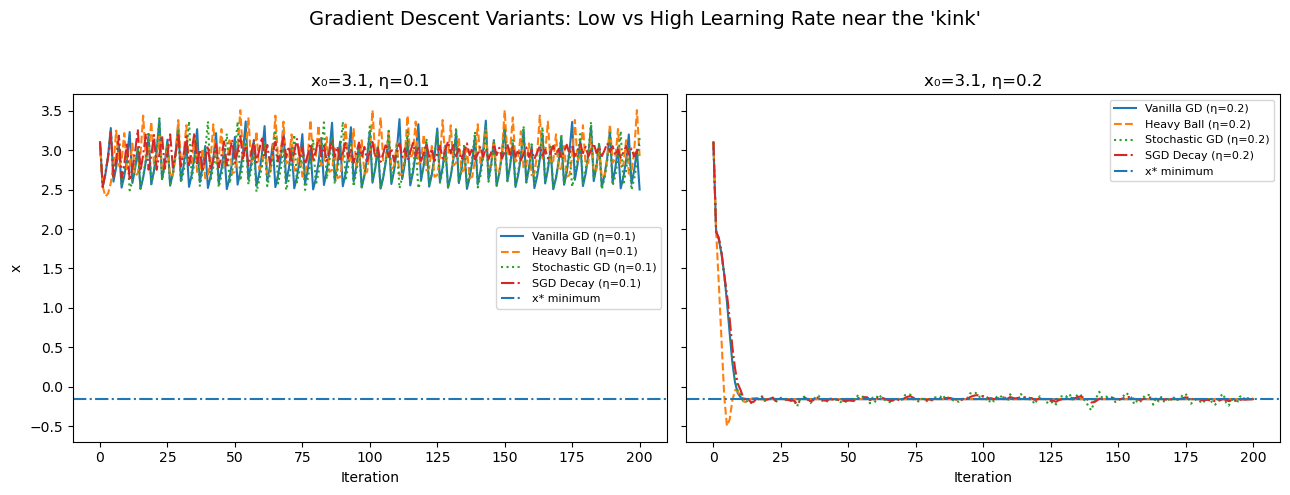

In [11]:
x0 = 3.1
K = 200
sigma = 0.2
beta = 0.5
gamma = 0.02
x_star = x_star

plot_gd_eta_comparison(
    x0=x0,
    etas=(0.1, 0.2),
    K=K,
    sigma=sigma,
    beta=beta,
    gamma=gamma,
    x_star=x_star,
    seed=42
)

The function’s non-smooth point at x=3 creates a “kink” that can trap gradient descent when the learning rate (η) is too small. In that case, updates bounce back and forth near the kink without enough momentum to escape, preventing convergence to the true minimum. When η is larger, the algorithm crosses the kink and continues toward x∗. This highlights how step-size choice determines whether the optimizer gets stuck in a flat or discontinuous region of the landscape.

<span style="font-size:16pt; font-weight:bold;">Alternative Initialisaton test</span>

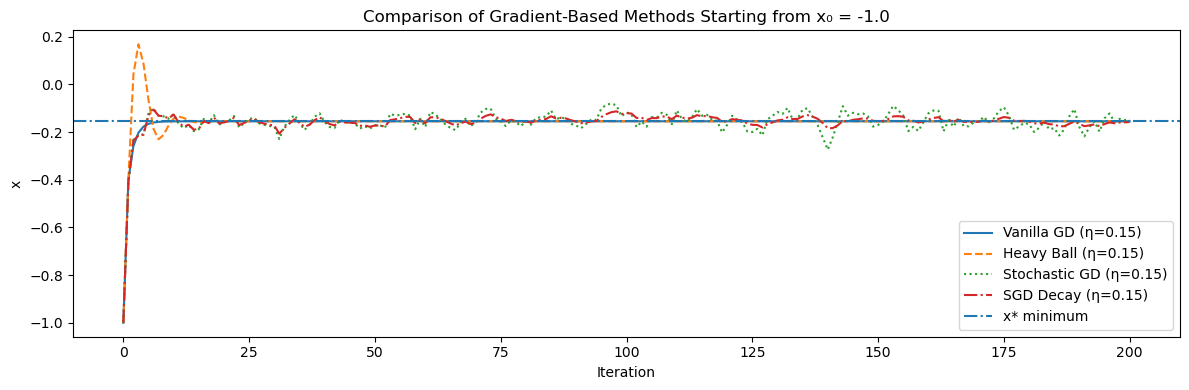

In [12]:
x0 = -1.0      
K = 200         
eta = 0.15
sigma = 0.2
beta = 0.5
gamma = 0.02
x_star = x_star  # minimum

"""
----------------------------------------------------------
 Additional experiment: initialization from x₀ = -1.0
----------------------------------------------------------
"""

# Run comparison for all four methods starting from x₀ = -1.0
results_neg = generate_gd_comparison_data(
    x0=x0,
    eta=eta,
    K=K,
    sigma=sigma,
    beta=beta,
    gamma=gamma,
    seed=42
)

plt.figure(figsize=(12, 4))
method_styles = {
    "Vanilla GD": {"color": "tab:blue", "linestyle": "-"},
    "Heavy Ball": {"color": "tab:orange", "linestyle": "--"},
    "Stochastic GD": {"color": "tab:green", "linestyle": ":"},
    "SGD Decay": {"color": "tab:red", "linestyle": "-."}
}

for method, (xs, fs) in results_neg.items():
    style = method_styles.get(method, {})
    plt.plot(xs, label=f"{method} (η={eta})", **style)

plt.axhline(y=x_star, linestyle="-.", label="x* minimum")
plt.title("Comparison of Gradient-Based Methods Starting from x₀ = -1.0")
plt.xlabel("Iteration")
plt.ylabel("x")
plt.legend()
plt.tight_layout()
plt.show()


<span style="font-size:16pt; font-weight:bold;">Analysis</span>

An extra run was included starting from \(x_0 = -1.0\). This test verifies how the algorithms behave when initialized on the opposite side of the minimum. Despite the non-smooth region around \(x = 3\), all methods eventually
converge toward \(x^*\), though the path length and oscillations differ.


In [13]:
from collections import OrderedDict
import numpy as np

def _compute_path_stats(xs, fs, *, x_star, f_func, tol=1e-1):
    """
    Return (endpoint_distance, best_objective_gap, first_hit_index or None).
    """
    xs = np.asarray(xs, dtype=float).ravel()
    fs = np.asarray(fs, dtype=float).ravel()
    if xs.size != fs.size:
        raise ValueError("xs and fs must have equal length")

    f_star = float(f_func(x_star))
    endpoint_distance = float(abs(xs[-1] - x_star))
    obj_err = np.abs(fs - f_star)
    best_objective_gap = float(obj_err.min())
    hits = np.where(obj_err < tol)[0]
    first_hit = int(hits[0]) if hits.size else None
    return endpoint_distance, best_objective_gap, first_hit

def _emit_single_report(label, xs, fs, *, x_star, f_func, tol):
    """
    Print a compact 3-line summary for one trajectory.
    """
    end_dist, best_gap, first_hit = _compute_path_stats(xs, fs, x_star=x_star, f_func=f_func, tol=tol)
    if label:
        print(label)
    print(f"• End-point distance |x_K − x*|: {end_dist}")
    print(f"• Best objective gap  min_k |f(x_k) − f(x*)|: {best_gap}")
    if first_hit is None:
        print(f"• First iteration with |f(x_k) − f(x*)| < {tol}: not achieved")
    else:
        print(f"• First iteration with |f(x_k) − f(x*)| < {tol}: {first_hit}")
    print()  # blank line

# --------------------------------------------------------------------
# Reports for build_results(...)  -> OrderedDict[label] = (xs, fs)
# --------------------------------------------------------------------
def report_build_results(results: OrderedDict, *, x_star, f_func, tol=1e-1):
    """
    Produce a two-part summary:
      (A) Stochastic GD (constant η)
      (B) Deterministic runs (GD + Heavy-Ball)
    """
    # Partition by label
    sgd_labels = [lbl for lbl in results if lbl.startswith("Stochastic GD")]
    det_labels = [lbl for lbl in results if (lbl.startswith("Gradient Descent") or lbl.startswith("Heavy Ball"))]

    # A) SGD constant-η
    print("=== Summary: Stochastic GD (constant η) ===\n")
    for lbl in sgd_labels:
        xs, fs = results[lbl]
        # Render a shorter label like: "σ=0.15 (constant η)"
        sig_text = lbl.replace("Stochastic GD", "").strip().strip("()")
        short = f"{sig_text} (constant η)"
        _emit_single_report(short, xs, fs, x_star=x_star, f_func=f_func, tol=tol)

    # B) Deterministic (GD + Heavy-Ball)
    print("=== Summary: Deterministic Methods (GD and Heavy-Ball) ===\n")
    for lbl in det_labels:
        xs, fs = results[lbl]
        # Tidy the plain GD label so it reads succinctly
        pretty = "GD (baseline)" if lbl == "Gradient Descent" else lbl
        _emit_single_report(pretty, xs, fs, x_star=x_star, f_func=f_func, tol=tol)

# --------------------------------------------------------------------
# Reports for generate_sgd_decay_data(...) -> dict[(eta0, gamma)] = (xs, fs)
# --------------------------------------------------------------------
def report_sgd_decay(results_decay: dict, *, x_star, f_func, sigma, tol=1e-1):
    """
    Summarize SGD with decaying learning rate schedules.
    """
    print("=== Summary: SGD with Decaying Learning Rate ===\n")
    for (eta0, gamma), (xs, fs) in results_decay.items():
        title = f"η₀={eta0}, γ={gamma}, σ={sigma}"
        _emit_single_report(title, xs, fs, x_star=x_star, f_func=f_func, tol=tol)



In [14]:
# After build_results(...)
report_build_results(results, x_star=x_star, f_func=f, tol=0.1)

# After generate_sgd_decay_data(...)
report_sgd_decay(results_decay, x_star=x_star, f_func=f, sigma=sigma, tol=0.1)

=== Summary: Stochastic GD (constant η) ===

σ=0.15 (constant η)
• End-point distance |x_K − x*|: 0.005514147261647007
• Best objective gap  min_k |f(x_k) − f(x*)|: 1.4287204468110826e-08
• First iteration with |f(x_k) − f(x*)| < 0.1: 10

σ=0.05 (constant η)
• End-point distance |x_K − x*|: 0.002180102754428148
• Best objective gap  min_k |f(x_k) − f(x*)|: 1.635389601517545e-10
• First iteration with |f(x_k) − f(x*)| < 0.1: 10

σ=0.5 (constant η)
• End-point distance |x_K − x*|: 0.12063399000371047
• Best objective gap  min_k |f(x_k) − f(x*)|: 5.362572085554351e-07
• First iteration with |f(x_k) − f(x*)| < 0.1: 13

σ=0.9 (constant η)
• End-point distance |x_K − x*|: 0.09798858117983139
• Best objective gap  min_k |f(x_k) − f(x*)|: 1.5857052417272977e-05
• First iteration with |f(x_k) − f(x*)| < 0.1: 8

=== Summary: Deterministic Methods (GD and Heavy-Ball) ===

GD (baseline)
• End-point distance |x_K − x*|: 5.551115123125783e-17
• Best objective gap  min_k |f(x_k) − f(x*)|: 0.0
• First

<span style="font-size:16pt; font-weight:bold;">Conclusion.</span>

This analysis traces how diferent gradient-based optimization methods behave when applied to a simple one-dimensional, non-smooth function with a kink at x=3. By comparing Gradient Descent (GD), Heavy-Ball Momentum, Stochastic Gradient Descent (SGD), and SGD with a decaying learning rate, we can see how changes in learning rate η momentum β, and noise σ influence convergence speed and stability.

The results show that:

<u>Heavy-Ball momentum</U> helps accelerate convergence compared with standard GD, but high momentum values (β≈0.9) can introduce oscillations and overshooting.

<u>Stochastic Gradient Descent</u> introduces randomness that mimics noisy data or gradients; small noise can help exploration, but large σ prevents stabilization.

<u>Decaying learning rates</u> improve robustness in the presence of noise, as gradually reducing η allows the method to settle near the minimum without excessive fluctuation.

<u>Around the kink at x=3</u> low learning rates can cause the optimizer to stall, while moderate or decaying rates let it cross the non-differentiable region effectively.

Overall, the exercise links the theory of calculus-based optimization to practical numerical behavior. It highlights how parameter choices—not just algorithms—govern convergence, stability, and the ability to reach the true minimum x∗.